In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
patients = '/media/ai-master/my_passport/joyce/stage1/2a48f50391e22040f28e258a74dcaf95/'
images = os.listdir(patients)
slices = [dicom.read_file(patients+'/'+s) for s in os.listdir(patients)]
slices = np.stack([s.pixel_array for s in slices])

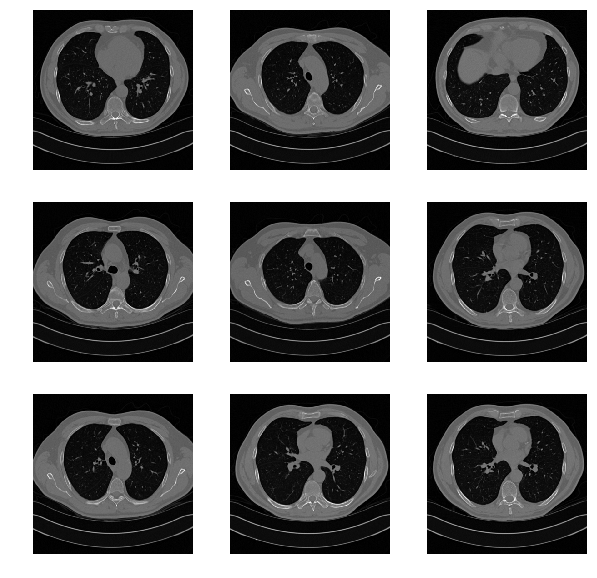

In [2]:
f, plots = plt.subplots(3, 3, figsize=(10, 10))
for i in range(0, slices.shape[0], 18):
    plots[int(i / 55), int((i) % 50)/17].axis('off')
    plots[int(i / 55), int((i) % 50)/17].imshow(slices[i], cmap=plt.cm.gray) 

    #slice[slice == -2000] = 0
#     plt.figure()
#     plt.imshow(slice)#cmap=plt.cm.gray)


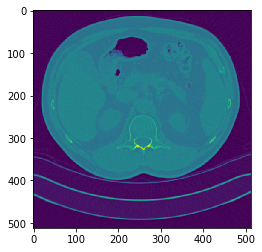

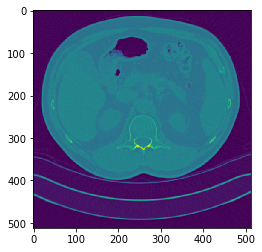

In [3]:
sample_image = slices[6]
plt.imshow(sample_image)
sample_image[sample_image==-2000]=2000
plt.figure()
plt.imshow(sample_image)

In [4]:
slices = [dicom.read_file(patients+'/'+s) for s in os.listdir(patients)]
slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
try:
    slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
except:
    slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

for s in slices:
    s.SliceThickness = slice_thickness

In [5]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [6]:
image = np.stack([s.pixel_array for s in slices])
new_image = get_pixels_hu(slices)
new_image,spacing = resample(image, slices, new_spacing=[1,1,1])

(170, 512, 512)
(340, 364, 364)


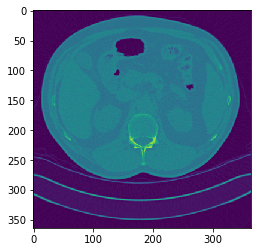

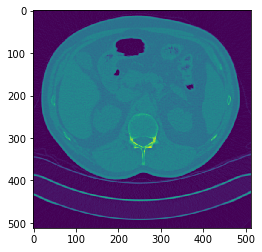

In [7]:
print np.shape(image)
print np.shape(new_image)
plt.imshow(new_image[0])
plt.figure()
plt.imshow(image[0])

In [9]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [ ]:
plot_3d(new_image, 200)